In [32]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# to display matplotlib plots inline (directly below the cell)
%matplotlib inline


Using device: cpu


In [33]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# get the MNIST dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=transform
)

# create data loaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Test dataset size:     {len(test_dataset)}")
print(f"Number of batches in training: {len(train_loader)}")
print(f"Number of batches in testing:  {len(test_loader)}")


Training dataset size: 60000
Test dataset size:     10000
Number of batches in training: 1875
Number of batches in testing:  313


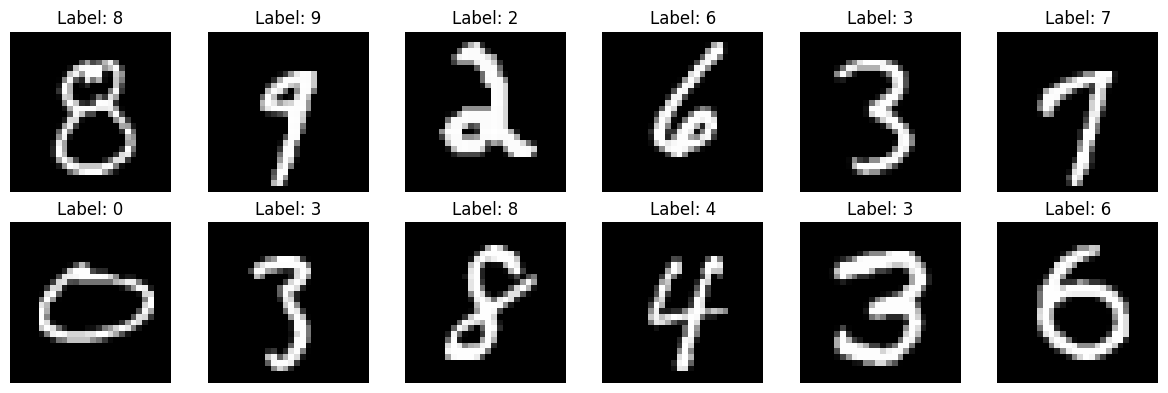

In [34]:
# get a batch of training data
images, labels = next(iter(train_loader))

fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i + 1)
    # remove normalization
    img = images[i].squeeze()
    img = img * 0.3081 + 0.1307
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Label: {labels[i].item()}')
    ax.axis('off')
plt.tight_layout()
plt.show()


In [35]:
class PCMNISTNet(nn.Module):
    def __init__(self):
        super(PCMNISTNet, self).__init__()
        self.W1 = nn.Linear(28*28, 256, bias=False)
        self.W2 = nn.Linear(256, 128, bias=False)
        self.W3 = nn.Linear(128, 64, bias=False)
        self.W4 = nn.Linear(64, 10, bias=False)
        # lateral connections for hidden layers 2 and 3
        self.L2 = nn.Linear(128, 128, bias=False)
        self.L3 = nn.Linear(64, 64, bias=False)
        for layer in [self.L2, self.L3]:
            nn.init.normal_(layer.weight, mean=0.0, std=0.01)
            mask = ~torch.eye(layer.weight.shape[0], dtype=torch.bool)
            layer.weight.data *= mask # to avoid self connection
        self.act = torch.relu

    def predict(self, x, lateral_strength=0.1):
        # forward pass to initialize latent states
        z0 = x.view(x.size(0), -1)
        z1 = self.act(self.W1(z0))
        z2_ff = self.act(self.W2(z1))
        lat2 = self.act(self.L2(z2_ff))
        z2 = z2_ff + lateral_strength * lat2
        z3_ff = self.act(self.W3(z2))
        lat3 = self.act(self.L3(z3_ff))
        z3 = z3_ff + lateral_strength * lat3
        z4 = self.W4(z3) # we want raw outputs here so no activation
        return [z0, z1, z2, z3, z4]

# Instantiate model
model = PCMNISTNet().to(device)
print(model)

PCMNISTNet(
  (W1): Linear(in_features=784, out_features=256, bias=False)
  (W2): Linear(in_features=256, out_features=128, bias=False)
  (W3): Linear(in_features=128, out_features=64, bias=False)
  (W4): Linear(in_features=64, out_features=10, bias=False)
  (L2): Linear(in_features=128, out_features=128, bias=False)
  (L3): Linear(in_features=64, out_features=64, bias=False)
)


In [36]:
inference_steps = 10
alpha = 0.05   # latent state learning rate
eta_weight = 0.01  # feed-forward weight learning rate
eta_lateral = 0.001  # lateral‑weight learning rate
lateral_strength = 0.1

@torch.no_grad()
def pc_train_batch(model, x, y_onehot):
    zs = model.predict(x, lateral_strength=lateral_strength)
    Ws = [model.W1, model.W2, model.W3, model.W4]
    Ls = [model.L2, model.L3]
    L  = len(Ws)
    zs[L] = y_onehot # clamps z4 with the true labels

    for _ in range(inference_steps):
        errors = [None]*(L+1)
        for l in range(1, L+1):
            if l < L:
                ff_pred = model.act(Ws[l-1](zs[l-1]))
                if l == 2:
                    lat_pred = model.act(Ls[0](zs[l]))
                    pred = ff_pred + lateral_strength * lat_pred
                elif l == 3:
                    lat_pred = model.act(Ls[1](zs[l]))
                    pred = ff_pred + lateral_strength * lat_pred
                else:
                    pred = ff_pred
            else:
                pred = Ws[l-1](zs[l-1])
            errors[l] = zs[l] - pred

        # updating the activation states of the hidden layers, Feed-forward and lateral weights
        for l in range(1, L):
            # the layer aligning itself with what the layer below says it should be
            td = -errors[l]
            # push zl in the direction that would reduce the error one layer up
            bu = errors[l+1] @ Ws[l].weight
            if l == 2:
                lat = lateral_strength * (errors[l] @ Ls[0].weight)
                zs[l] += alpha * (td + bu + lat)
            elif l == 3:
                lat = lateral_strength * (errors[l] @ Ls[1].weight)
                zs[l] += alpha * (td + bu + lat)
            else:
                zs[l] += alpha * (td + bu)

            # Incremental feedforward‐weight update
            grad_W = errors[l+1].t() @ zs[l]
            Ws[l].weight.data += eta_weight * (grad_W / x.size(0))

            # Incremental lateral weight update
            if l in (2, 3):
                idx = l - 2  # 0 for layer2, 1 for layer3
                L_layer = Ls[idx]
                grad_L = errors[l].t() @ zs[l]
                mask = ~torch.eye(L_layer.weight.shape[0], dtype=torch.bool, device=grad_L.device)
                grad_L *= mask
                L_layer.weight.data += eta_lateral * (grad_L / x.size(0))

    final_errors = []
    for l in range(1, L+1):
        if l < L:
            ff = model.act(Ws[l-1](zs[l-1]))
            if   l == 2: lat = lateral_strength * model.act(Ls[0](zs[l]))
            elif l == 3: lat = lateral_strength * model.act(Ls[1](zs[l]))
            else:        lat = 0.0
            pred = ff + lat
        else:
            pred = Ws[l-1](zs[l-1])
        final_errors.append(zs[l] - pred)

    return final_errors, zs


In [37]:
num_epochs = 5
prediction_errors = []
test_accuracies = []

for epoch in range(1, num_epochs+1):
    total_error = 0.0
    batches = 0

    model.train()
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch}", leave=True):
        images, labels = images.to(device), labels.to(device)
        y_onehot = torch.zeros(images.size(0), 10, device=device)
        y_onehot.scatter_(1, labels.view(-1,1), 1.0)

        final_errors, _ = pc_train_batch(model, images, y_onehot)
        batch_error = final_errors[-1].abs().mean().item() # computes the average absolute error across the batch
        total_error += batch_error
        batches += 1

    avg_error = total_error / batches
    prediction_errors.append(avg_error)

    # Test accuracy
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            zs = model.predict(images)
            preds = zs[-1].argmax(dim=1) # changes logits to classes
            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)

    test_acc = test_correct / test_total
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch}:")
    print(f"  Prediction error: {avg_error:.4f}")
    print(f"  Test accuracy: {test_acc:.4f}")

Epoch 1: 100%|██████████| 1875/1875 [00:43<00:00, 43.03it/s]


Epoch 1:
  Prediction error: 0.0574
  Test accuracy: 0.8078


Epoch 2: 100%|██████████| 1875/1875 [00:42<00:00, 43.79it/s]


Epoch 2:
  Prediction error: 0.0182
  Test accuracy: 0.8396


Epoch 3: 100%|██████████| 1875/1875 [00:37<00:00, 49.86it/s]


Epoch 3:
  Prediction error: 0.0134
  Test accuracy: 0.8468


Epoch 4: 100%|██████████| 1875/1875 [00:38<00:00, 48.35it/s]


Epoch 4:
  Prediction error: 0.0113
  Test accuracy: 0.8477


Epoch 5: 100%|██████████| 1875/1875 [00:42<00:00, 43.64it/s]


Epoch 5:
  Prediction error: 0.0101
  Test accuracy: 0.8447


In [38]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        zs = model.predict(images)
        preds = zs[-1].argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Test accuracy: {correct/total:.4f}")


Test accuracy: 0.8447


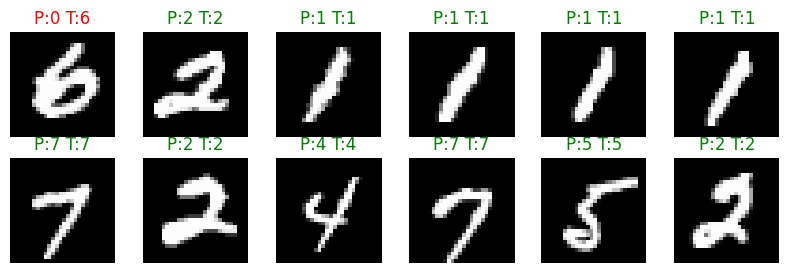

In [41]:
import random

test_batches = list(test_loader)
test_images, test_labels = random.choice(test_batches)
test_images = test_images.to(device)
zs = model.predict(test_images)
preds = zs[-1].argmax(dim=1)

fig = plt.figure(figsize=(10, 3))
for i in range(12):
    ax = fig.add_subplot(2, 6, i + 1)
    img = test_images[i].cpu().squeeze() * 0.3081 + 0.1307
    ax.imshow(img, cmap='gray')
    color = 'green' if preds[i]==test_labels[i] else 'red'
    ax.set_title(f"P:{preds[i].item()} T:{test_labels[i].item()}", color=color)
    ax.axis('off')
plt.show()


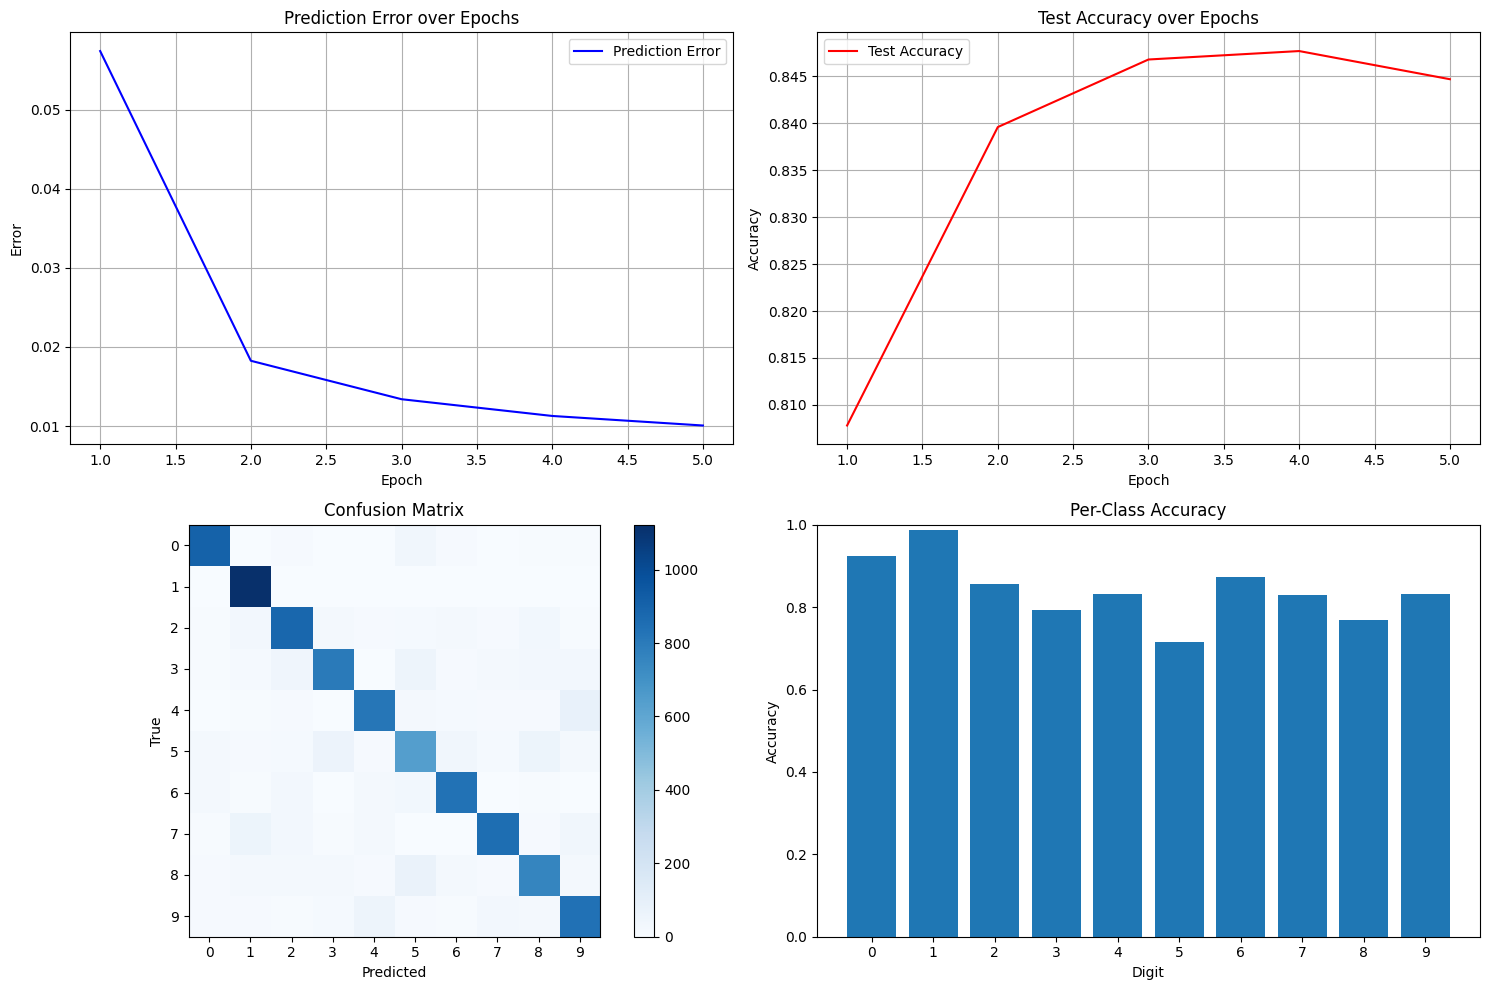


Per-class accuracies:
Digit 0: 0.9235
Digit 1: 0.9885
Digit 2: 0.8566
Digit 3: 0.7941
Digit 4: 0.8330
Digit 5: 0.7152
Digit 6: 0.8727
Digit 7: 0.8298
Digit 8: 0.7700
Digit 9: 0.8315


In [42]:
plt.figure(figsize=(15, 10))

# Plot 1: Prediction Error
plt.subplot(2, 2, 1)
plt.plot(range(1, num_epochs + 1), prediction_errors, 'b-', label='Prediction Error')
plt.title('Prediction Error over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.grid(True)
plt.legend()

# Plot 2: Test Accuracy
plt.subplot(2, 2, 2)
plt.plot(range(1, num_epochs + 1), test_accuracies, 'r-', label='Test Accuracy')
plt.title('Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Plot 3: Confusion Matrix
plt.subplot(2, 2, 3)
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        zs = model.predict(images)
        preds = zs[-1].argmax(dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

conf_matrix = np.zeros((10, 10))
for t, p in zip(y_true, y_pred):
    conf_matrix[t, p] += 1

plt.xticks(np.arange(10), [str(i) for i in range(10)])
plt.yticks(np.arange(10), [str(i) for i in range(10)])
plt.imshow(conf_matrix, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')

# Plot 4: Per-Class Accuracy
plt.subplot(2, 2, 4)
per_class_acc = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
plt.bar(range(10), per_class_acc)
plt.title('Per-Class Accuracy')
plt.xlabel('Digit')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(np.arange(10), [str(i) for i in range(10)])
plt.tight_layout()
plt.show()

print("\nPer-class accuracies:")
for digit, acc in enumerate(per_class_acc):
    print(f"Digit {digit}: {acc:.4f}")
